# Twitter Disaster Detection Model 

In [ ]:
! pip3 install -r requirements.txt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import random
import torch
from torch import nn, optim
import math
from IPython import display
import requests
import torch.nn.functional as F

### Pre-processing

Preprocessing done in a seperate file and saved in preprocessed_(test/tain).csv, so the long process does not need to occur each run

### Device

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Import CSV's

In [3]:
train_df = pd.read_csv('preprocessed_train.csv', sep=',', encoding='latin-1')
test_df = pd.read_csv("test.csv")

In [4]:
data = train_df[['keyword', 'location', 'sarcastic', 'not_sarcastic', 'negative', 'neutral', 'positive']]
target = train_df['target']

#print(X_data["neutral"])
#train_data, val_data, train_target, val_target = train_test_split(data, target, test_size = 0.2)
#print(train_target)
# split the dataset into training and validation sets
#train_data, val_data = 
#print(train_data[:]["sarcastic"])
#train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

### Convert categorical features in a DataFrame to one-hot encoding

In [ ]:
def convert_features_to_one_hot(df, feature_name_list):
  for feature_name in feature_name_list:
    df = pd.get_dummies(df, columns=[feature_name])
  
  return df
#Define the training set/test set from the imported data... x_train, x_val, etc... needs to be predefined

feature_list = ['location', 'keyword']

#data_to_convert = ['train_data', 'val_data']
#for i,ix in enumerate(data_to_convert):
#  exec(f'{data_to_convert[i]} = convert_features_to_one_hot({ix}, {feature_list})')

data = convert_features_to_one_hot(data, feature_list)

train_data, val_data, train_target, val_target = train_test_split(data, target, test_size = 0.2)
print(train_target)

In [6]:
print(len(train_data.keys()))
input_layers = len(train_data.keys())

3565


### Model draft 

In [68]:
class netmodel(nn.Module):
  def __init__(self, input_layer=1, num_hidden=1, node_per_hidden=32, droppout=0., LSTM_layers=0, outputs=2):
    super(netmodel, self).__init__()
    self.input_layer = input_layer
    self.num_hidden = num_hidden 
    self.node_per_hidden = node_per_hidden
    self.droppout = droppout 
    self.SLTM_layers = LSTM_layers 
    self.outputs = outputs 
    self.inputfc = nn.Linear(input_layer, node_per_hidden)
    self.hiddenfc = [] 
    for i in range(num_hidden-1):
      self.hiddenfc.append(nn.Linear(node_per_hidden, node_per_hidden).to(device))
    self.lastfc = nn.Linear(node_per_hidden, outputs)

  def forward(self, x, debug=False):
    drop = nn.Dropout(p=self.droppout)
    #x = x.view(1,1)
    x = self.inputfc(x)
    x = F.relu(x)
    x = drop(x)
    for i in range(self.num_hidden-1):
      x = self.hiddenfc[i](x)
      x = F.relu(x)
      x = drop(x)
    
    x = self.lastfc(x)
    x = F.softmax(x, dim=1)
    return x 

In [265]:
Model = netmodel(input_layer=input_layers, num_hidden=10, node_per_hidden=input_layers, droppout=0.3).to(device)

#Model.forward(torch.tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]))

### Build loaders + set variables

In [266]:
batch_size = 32
print(len(train_data))
print(len(train_target))
#tensor_train = torch.utils.data.TensorDataset(train_data, train_target)
tensor_train = torch.tensor(train_data.values.astype(float), dtype=torch.float32).to(device)
tensor_train_labels = torch.tensor(train_target.values.astype(float), dtype=torch.long).to(device)
tensor_train_set = torch.utils.data.TensorDataset(tensor_train, tensor_train_labels)

# Convert validation data to PyTorch tensors and move to device
#tensor_val = torch.utils.data.TensorDataset(val_data, val_target)
tensor_val = torch.tensor(val_data.values.astype(float), dtype=torch.float32).to(device)
tensor_val_labels = torch.tensor(val_target.values.astype(float), dtype=torch.long).to(device)
tensor_val_set = torch.utils.data.TensorDataset(tensor_val, tensor_val_labels)

train_loader = torch.utils.data.DataLoader(tensor_train_set, batch_size=batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(tensor_val_set, batch_size=batch_size, shuffle=True)

lr = 1e-2
lambda_l2 = 1e-3
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(Model.parameters(), lr=lr)

6088
6088


In [267]:
def train_model(epochs, model):
    losses = []
    accuracies = []
    val_accuracies = []

    model.train()
    for epoch in range(epochs):
      for batch_id, (data, label) in enumerate(train_loader):
        #print(batch_idx)

        pred = Model.forward(data)
        #print(type(pred[0][0].item()))

        optimizer.zero_grad()
        loss = loss_func(pred, label)
        
        #print(loss)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())

        # Calculate accuracy for current batch
        _, predicted = torch.max(pred, 1)
        accuracy = torch.sum(predicted == label).item() / label.size(0)
        accuracies.append(accuracy)

        # Uncomment to calculate validation accuracy (takes more time)
        #val_accuracy, _, _, _ = validate_model(model, val_loader, False)
        #val_accuracies.append(val_accuracy)

        if batch_id % 100 == 0:
          #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTrain Accuracy: {:.4f}\tValidation Accuracy: {:.4f}'.format(
          #  epoch, batch_id * len(data), len(train_loader.dataset),
          #  100. * batch_id / len(train_loader), loss.item(), accuracy, val_accuracy))
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTrain Accuracy: {:.4f}'.format(
            epoch, batch_id * len(data), len(train_loader.dataset),
            100. * batch_id / len(train_loader), loss.item(), accuracy))
          
    return losses, accuracies, val_accuracies

In [268]:
losses, accuracies, val_accuracies = train_model(10, Model)

Train Epoch: 0 [0/6088 (0%)]	Loss: 0.692537	Train Accuracy: 0.5938
Train Epoch: 0 [3200/6088 (52%)]	Loss: 0.649943	Train Accuracy: 0.6875
Train Epoch: 1 [0/6088 (0%)]	Loss: 0.675288	Train Accuracy: 0.6250
Train Epoch: 1 [3200/6088 (52%)]	Loss: 0.662230	Train Accuracy: 0.6250
Train Epoch: 2 [0/6088 (0%)]	Loss: 0.684389	Train Accuracy: 0.5625
Train Epoch: 2 [3200/6088 (52%)]	Loss: 0.660857	Train Accuracy: 0.6250
Train Epoch: 3 [0/6088 (0%)]	Loss: 0.738633	Train Accuracy: 0.4375
Train Epoch: 3 [3200/6088 (52%)]	Loss: 0.695681	Train Accuracy: 0.5312
Train Epoch: 4 [0/6088 (0%)]	Loss: 0.707819	Train Accuracy: 0.5000
Train Epoch: 4 [3200/6088 (52%)]	Loss: 0.686160	Train Accuracy: 0.5625
Train Epoch: 5 [0/6088 (0%)]	Loss: 0.720682	Train Accuracy: 0.3438
Train Epoch: 5 [3200/6088 (52%)]	Loss: 0.671374	Train Accuracy: 0.5938
Train Epoch: 6 [0/6088 (0%)]	Loss: 0.667331	Train Accuracy: 0.5625
Train Epoch: 6 [3200/6088 (52%)]	Loss: 0.649408	Train Accuracy: 0.6250
Train Epoch: 7 [0/6088 (0%)]	Loss:

In [ ]:
# Compare train and validation accuracy during training
plt.plot(accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracies')
plt.legend()
plt.show()

0.6925369


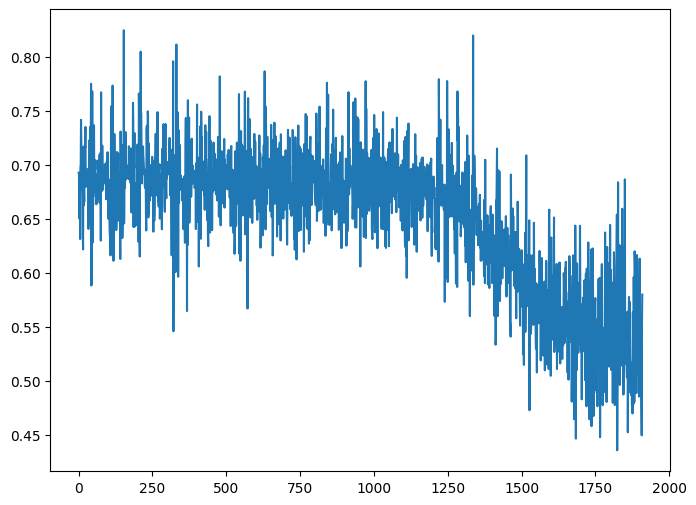

In [269]:
fig, ax = plt.subplots(figsize=(8, 6))
print(losses[0])
ax.plot(range(0, len(losses)), losses)

0.59375


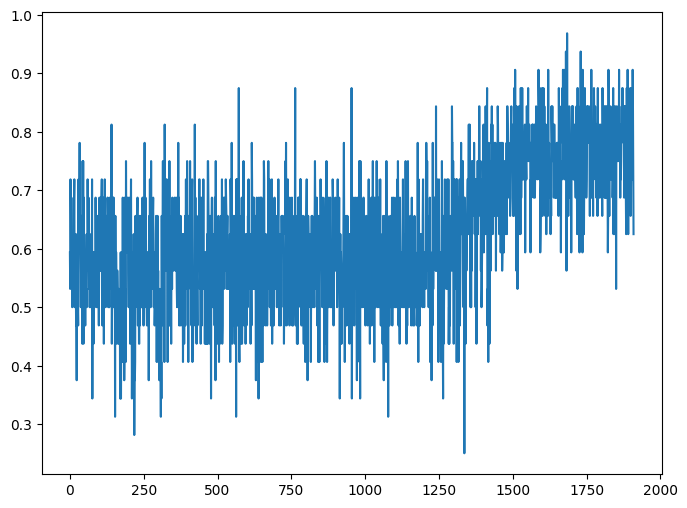

In [270]:
fig, ax = plt.subplots(figsize=(8, 6))
print(accuracies[0])
ax.plot(range(0, len(accuracies)), accuracies)

In [21]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [273]:
def validate_model(model, loader, is_test=True):
    model.eval()
    #losses = []
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    with torch.no_grad():
      for batch_id, (data, label) in enumerate(loader):

        data = data.to(device)
        label = label.to(device)

        outputs = model(data)
        #_, predicted = torch.max(outputs.data, 1)
        probabilities = F.softmax(outputs, dim=1)  # Compute predicted probabilities
        _, predicted = torch.max(probabilities, 1)

        true_labels.extend(label.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        predicted_probs.extend(probabilities[:, 1].cpu().numpy())  # Assuming class 1 is the positive class

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    predicted_probs = np.array(predicted_probs)

    accuracy = accuracy_score(true_labels, predicted_labels)

    if is_test:
      precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
      return accuracy, precision, recall, f1, true_labels, predicted_labels, predicted_probs
    else:
      return accuracy, true_labels, predicted_labels, predicted_probs

In [274]:
#validate_model(Model, val_loader)

accuracy, precision, recall, f1, true_labels, predicted_labels, predicted_probs = validate_model(Model, val_loader)
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

Accuracy: 0.7352
Precision: 0.7377
Recall: 0.7352
F1 Score: 0.7310


## Evaluation Visualizations

In [164]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
import seaborn as sns

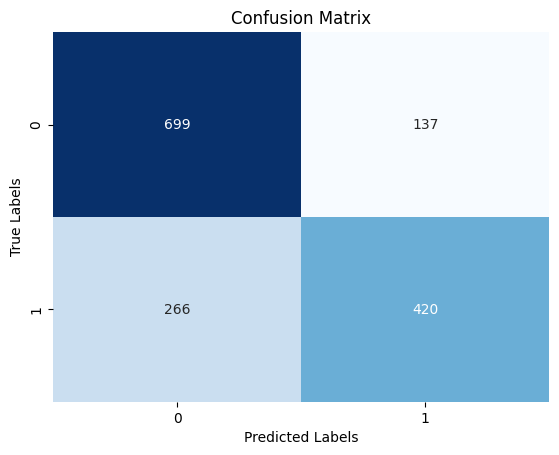

In [275]:
def plot_confusion_matrix(true_labels, predicted_labels):
    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Create a heatmap for the confusion matrix
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)

    # Set axis labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

plot_confusion_matrix(true_labels, predicted_labels)

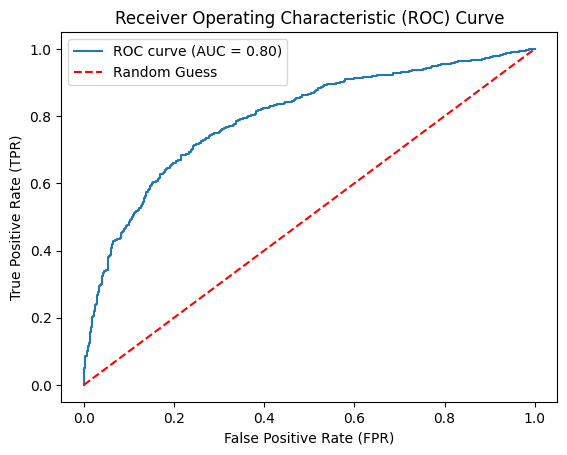

In [276]:
def plot_roc_curve(true_labels, predicted_probs):
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    auc = roc_auc_score(true_labels, predicted_probs)

    plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
    plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guess')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

plot_roc_curve(true_labels, predicted_probs)

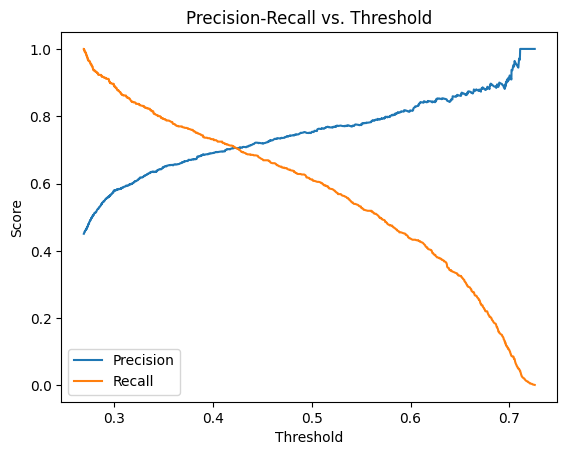

In [277]:
def plot_precision_recall_vs_threshold(y_true, y_scores):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    plt.plot(thresholds, precision[:-1], label='Precision')
    plt.plot(thresholds, recall[:-1], label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision-Recall vs. Threshold')
    plt.legend()
    plt.show()

plot_precision_recall_vs_threshold(true_labels, predicted_probs)